Lets re-fit polynomial regression fits for the exposure time factor using a combination of BOSS sky flux data and DESI CMX sky flux data.

**updates**: 
- April 8, 2020: LinearRegression adjusted to Ridge so that the coefficients are regularized. Exposure factor model fit to sky fluxes at 7000A because exposure factor based on 4500A ended up being too conservative (i.e. too large)

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import os
import h5py
import fitsio
import numpy as np 
from astropy import units as u
from scipy.signal import medfilt
from feasibgs import skymodel as Sky
# --- desihub ---
import desisim.simexp

INFO:utils.py:79:freeze_iers: Freezing IERS table used by astropy time, coordinates.


In [2]:
# -- plotting -- 
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False

In [3]:
dir_cmx = '/Users/ChangHoon/data/feasiBGS/cmx/'
dir_sky = '/Users/ChangHoon/data/feasiBGS/sky/'

In [4]:
desi_fiber_area = (1.46/2.)**2 * np.pi
boss_fiber_area = np.pi

In [5]:
def read_cmx_skies(): 
    ''' read CMX sky fibers and return median sky surface brightness measurements for each exposure
    '''
    fsky = h5py.File(os.path.join(dir_cmx, 'sky_fibers.coadd_gfa.minisv2_sv0.hdf5'), 'r')

    sky_data = {}
    for k in fsky.keys():
        sky_data[k] = fsky[k][...]
        
    bad_seeing = (sky_data['tileid'] == 70502) | (sky_data['date'] == 20200314) #bad seeing on Feb 25 and 27

    exp_cuts = ~bad_seeing

    for k in sky_data.keys(): 
        if 'wave' not in k: 
            sky_data[k] = sky_data[k][exp_cuts]
        else:
            sky_data[k] = sky_data[k]
            
    uniq_exps, i_uniq = np.unique(sky_data['expid'], return_index=True)

    # compile median observing conditions for each unique exposure and
    # get the median sky fluxes of all sky fibers
    sky_uniq_exps = {} 
    for k in ['date', 'tileid', 'expid', 'airmass', 'moon_ill', 'moon_alt', 'moon_sep', 'exptime']: 
        sky_uniq_exps[k] = np.zeros(len(uniq_exps))

    sky_uniq_exps['wave_b'] = sky_data['wave_b']
    sky_uniq_exps['wave_r'] = sky_data['wave_r']
    sky_uniq_exps['wave_z'] = sky_data['wave_z']
    
    sky_uniq_exps['sky_b'] = np.zeros((len(uniq_exps), len(sky_data['wave_b'])))
    sky_uniq_exps['sky_r'] = np.zeros((len(uniq_exps), len(sky_data['wave_r'])))
    sky_uniq_exps['sky_z'] = np.zeros((len(uniq_exps), len(sky_data['wave_z'])))
    
    print('date \t\t tile \t exp \t texp \t airmass \t moon_ill \t moon_alt \t moon_sep')
    for _i, _i_uniq, _exp in zip(range(len(i_uniq)), i_uniq, uniq_exps): 
        _is_exp = (sky_data['expid'] == _exp)

        sky_uniq_exps['date'][_i] = sky_data['date'][_i_uniq]
        sky_uniq_exps['tileid'][_i] = sky_data['tileid'][_i_uniq]
        sky_uniq_exps['expid'][_i] = sky_data['expid'][_i_uniq]
        sky_uniq_exps['airmass'][_i] = np.median(sky_data['airmass'][_is_exp])
        sky_uniq_exps['moon_ill'][_i] = np.median(sky_data['moon_ill'][_is_exp])
        sky_uniq_exps['moon_alt'][_i] = np.median(sky_data['moon_alt'][_is_exp])
        sky_uniq_exps['moon_sep'][_i] = np.median(sky_data['moon_sep'][_is_exp])
        sky_uniq_exps['exptime'][_i] = sky_data['exptime'][_is_exp][0]
        
        sky_uniq_exps['sky_b'][_i] = np.median(sky_data['sky_b'][_is_exp], axis=0) / desi_fiber_area
        sky_uniq_exps['sky_r'][_i] = np.median(sky_data['sky_r'][_is_exp], axis=0) / desi_fiber_area
        sky_uniq_exps['sky_z'][_i] = np.median(sky_data['sky_z'][_is_exp], axis=0) / desi_fiber_area

        print('%i \t %i \t %i \t %.f \t %.2f \t\t %.2f \t\t %.1f \t\t %f' % 
              (sky_data['date'][_i_uniq], sky_data['tileid'][_i_uniq], sky_data['expid'][_i_uniq], 
               sky_uniq_exps['exptime'][_i], 
               sky_uniq_exps['airmass'][_i], sky_uniq_exps['moon_ill'][_i], 
               sky_uniq_exps['moon_alt'][_i], sky_uniq_exps['moon_sep'][_i]))

    return sky_uniq_exps

In [6]:
def read_BOSS_skies(): 
    ''' read sky fibers from BOSS
    '''
    f_boss = os.path.join(dir_sky, 'Bright_BOSS_Sky_blue.fits')
    boss = fitsio.read(f_boss)    
    f_red = os.path.join(dir_sky, 'Bright_BOSS_Sky_red.fits')
    red = fitsio.read(f_red)
    
    sky_boss = {} 
    sky_boss['airmass'] = boss['AIRMASS']
    sky_boss['moon_ill'] = boss['MOON_ILL']
    sky_boss['moon_alt'] = boss['MOON_ALT']
    sky_boss['moon_sep'] = boss['MOON_SEP']
    
    sky_boss['wave_b'] = boss['WAVE'] * 10. # convert to Angstroms
    sky_boss['sky_b'] = boss['SKY'] / boss_fiber_area
    sky_boss['wave_r'] = red['WAVE'] * 10.
    sky_boss['sky_r'] = red['SKY'] / boss_fiber_area
    return sky_boss

In [7]:
cmx_skies = read_cmx_skies()

date 		 tile 	 exp 	 texp 	 airmass 	 moon_ill 	 moon_alt 	 moon_sep
20200303 	 70500 	 52932 	 500 	 1.15 		 0.65 		 35.8 		 34.694952
20200303 	 70500 	 52934 	 500 	 1.19 		 0.65 		 31.0 		 34.560475
20200303 	 70500 	 52936 	 500 	 1.25 		 0.65 		 26.2 		 34.426285
20200303 	 70500 	 52938 	 500 	 1.31 		 0.65 		 21.6 		 34.295422
20200303 	 70500 	 52940 	 500 	 1.39 		 0.65 		 17.0 		 34.164750
20200303 	 70500 	 52942 	 500 	 1.49 		 0.66 		 12.2 		 34.028773
20200304 	 70510 	 53078 	 500 	 1.43 		 0.74 		 55.8 		 79.213270
20200304 	 70510 	 53080 	 500 	 1.34 		 0.75 		 52.1 		 79.065745
20200304 	 70510 	 53081 	 500 	 1.29 		 0.75 		 49.2 		 78.948088
20200304 	 70510 	 53082 	 500 	 1.24 		 0.75 		 46.4 		 78.831239
20200304 	 70510 	 53083 	 500 	 1.19 		 0.75 		 43.5 		 78.713989
20200304 	 70510 	 53084 	 500 	 1.16 		 0.75 		 40.7 		 78.597620
20200304 	 70510 	 53085 	 500 	 1.13 		 0.75 		 37.8 		 78.480931
20200304 	 70510 	 53086 	 500 	 1.10 		 0.75 		 34.9 		 78.

In [8]:
boss_skies = read_BOSS_skies()

[]

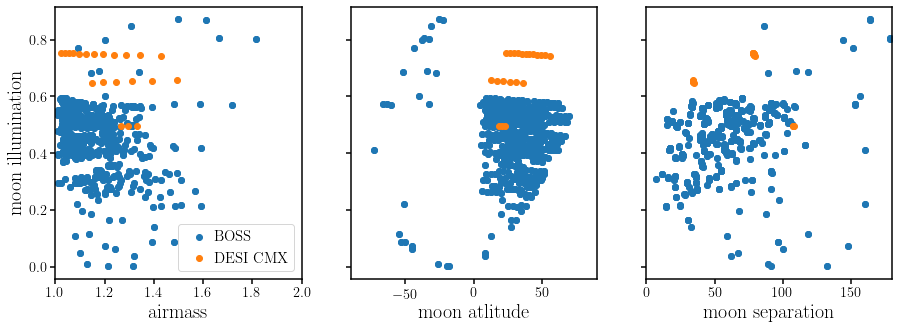

In [9]:
fig = plt.figure(figsize=(15,5))
sub = fig.add_subplot(131)
sub.scatter(boss_skies['airmass'], boss_skies['moon_ill'], c='C0', label='BOSS')
sub.scatter(cmx_skies['airmass'], cmx_skies['moon_ill'], c='C1', label='DESI CMX')
sub.legend(loc='lower right', frameon=True, handletextpad=0, fontsize=15)
sub.set_xlabel('airmass', fontsize=20)
sub.set_xlim(1., 2.)
sub.set_ylabel('moon illumination', fontsize=20)

sub = fig.add_subplot(132)
sub.scatter(boss_skies['moon_alt'], boss_skies['moon_ill'], c='C0')
sub.scatter(cmx_skies['moon_alt'], cmx_skies['moon_ill'], c='C1')
sub.set_xlabel('moon atlitude', fontsize=20)
sub.set_xlim(-90., 90.)
sub.set_yticklabels([])

sub = fig.add_subplot(133)
sub.scatter(boss_skies['moon_sep'], boss_skies['moon_ill'], c='C0', label='BOSS')
sub.scatter(cmx_skies['moon_sep'], cmx_skies['moon_ill'], c='C1', label='DESI CMX')
sub.set_xlabel('moon separation', fontsize=20)
sub.set_xlim(0., 180.)
sub.set_yticklabels([])

In [10]:
# nominal dark sky
wave_lin    = np.linspace(3.6e3, 9.8e3, 62001) 
config      = desisim.simexp._specsim_config_for_wave(wave_lin, dwave_out=None, specsim_config_file='desi')
atm_config  = config.atmosphere
sb_dict     = config.load_table(atm_config.sky, 'surface_brightness', as_dict=True)
Isky_dark   = sb_dict['dark']

In [11]:
Isky_cont_dark = medfilt(Isky_dark, 1001)
Isky_cont_dark_4500 = np.median(Isky_cont_dark[(wave_lin > 4450) & (wave_lin < 4550)])
Isky_cont_dark_7000 = np.median(Isky_cont_dark[(wave_lin > 6950) & (wave_lin < 7050)])

Lets compare the model and data from randomly chosen exposures

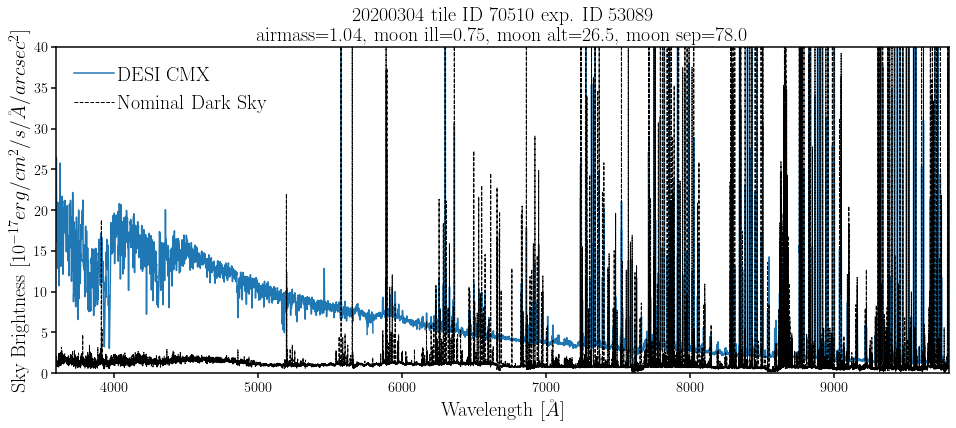

In [12]:
fig = plt.figure(figsize=(16, 6))
sub = fig.add_subplot(111)

iexp = np.random.choice(np.arange(len(cmx_skies['airmass'])))
sub.plot(cmx_skies['wave_b'], cmx_skies['sky_b'][iexp], c='C0')
sub.plot(cmx_skies['wave_r'], cmx_skies['sky_r'][iexp], c='C0')
sub.plot(cmx_skies['wave_z'], cmx_skies['sky_z'][iexp], c='C0', label='DESI CMX')
sub.plot(wave_lin, Isky_dark, c='k', ls='--', lw=1, label='Nominal Dark Sky')
sub.set_title('%i tile ID %i exp. ID %i\nairmass=%.2f, moon ill=%.2f, moon alt=%.1f, moon sep=%.1f' % 
              (cmx_skies['date'][iexp], cmx_skies['tileid'][iexp], cmx_skies['expid'][iexp], 
               cmx_skies['airmass'][iexp], cmx_skies['moon_ill'][iexp], 
               cmx_skies['moon_alt'][iexp], cmx_skies['moon_sep'][iexp]), fontsize=20)
sub.set_xlabel("Wavelength [$\AA$]", fontsize=20)
sub.set_xlim(3600, 9800)
sub.set_ylabel('Sky Brightness [$10^{-17} erg/cm^{2}/s/\AA/arcsec^2$]', fontsize=20)
sub.set_ylim(0., 40.)
sub.legend(loc='upper left', fontsize=20, handletextpad=0.2)

Text(0.5, 0, 'Wavelength [$\\AA$]')

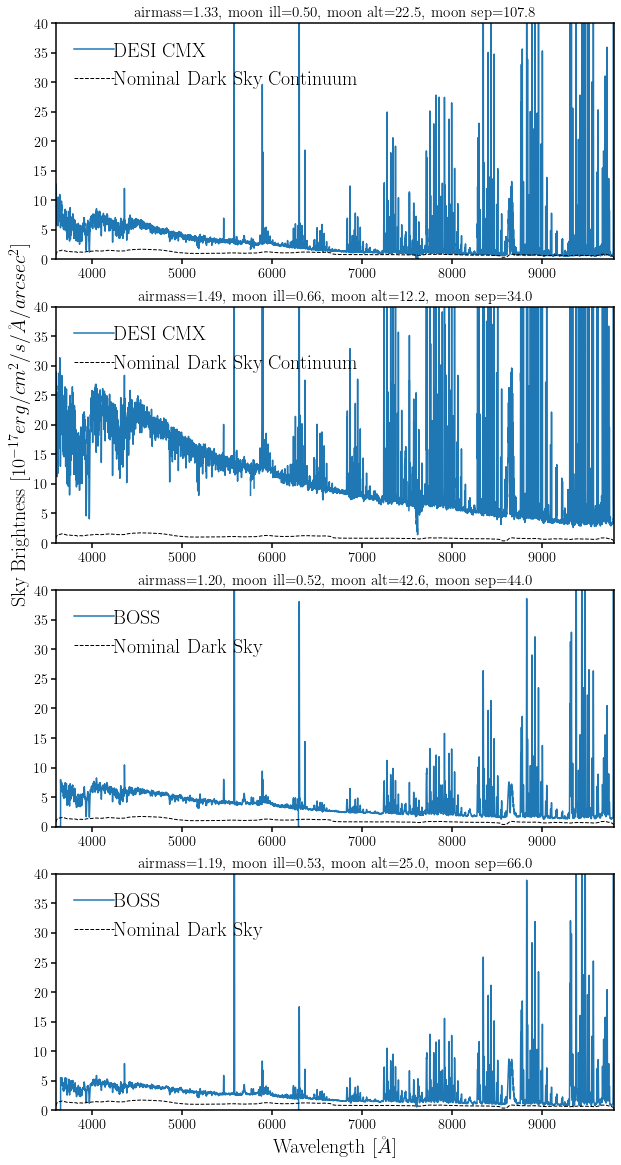

In [13]:
fig = plt.figure(figsize=(10, 20))
for i, iexp in enumerate(np.random.choice(np.arange(len(cmx_skies['airmass'])), size=2, replace=False)):
    sub = fig.add_subplot(4,1,i+1)
    sub.plot(cmx_skies['wave_b'], cmx_skies['sky_b'][iexp], c='C0')
    sub.plot(cmx_skies['wave_r'], cmx_skies['sky_r'][iexp], c='C0')
    sub.plot(cmx_skies['wave_z'], cmx_skies['sky_z'][iexp], c='C0', label='DESI CMX')
    sub.plot(wave_lin, Isky_cont_dark, c='k', ls='--', lw=1, label='Nominal Dark Sky Continuum')
    sub.set_title('airmass=%.2f, moon ill=%.2f, moon alt=%.1f, moon sep=%.1f' % 
                  (cmx_skies['airmass'][iexp], cmx_skies['moon_ill'][iexp], 
                   cmx_skies['moon_alt'][iexp], cmx_skies['moon_sep'][iexp]), fontsize=15)
    sub.set_xlim(3600, 9800)
    sub.set_ylim(0., 40.)
    sub.legend(loc='upper left', fontsize=20, handletextpad=0)
sub.set_ylabel('Sky Brightness [$10^{-17} erg/cm^{2}/s/\AA/arcsec^2$]', fontsize=20)
    
for i, iexp in enumerate(np.random.choice(np.arange(len(boss_skies['airmass'])), size=2, replace=False)):
    sub = fig.add_subplot(4,1,i+3)
    sub.plot(boss_skies['wave_b'][iexp], boss_skies['sky_b'][iexp], c='C0', label='BOSS')
    sub.plot(boss_skies['wave_r'][iexp], boss_skies['sky_r'][iexp], c='C0')
    sub.plot(wave_lin, Isky_cont_dark, c='k', ls='--', lw=1, label='Nominal Dark Sky')
    sub.set_title('airmass=%.2f, moon ill=%.2f, moon alt=%.1f, moon sep=%.1f' % 
                  (boss_skies['airmass'][iexp], boss_skies['moon_ill'][iexp], 
                   boss_skies['moon_alt'][iexp], boss_skies['moon_sep'][iexp]), fontsize=15)
    sub.legend(loc='upper left', fontsize=20, handletextpad=0)
    sub.set_xlim(3600, 9800)
    sub.set_ylim(0., 40.)
sub.set_xlabel("Wavelength [$\AA$]", fontsize=20)

In [14]:
def get_exposure_factor(wave, Isky, wavelength=4500., data_set='desi'): 
    wave = wave[np.isfinite(Isky)]
    Isky = Isky[np.isfinite(Isky)]
    if data_set == 'boss': 
        wave = wave[::10]
        Isky_cont = medfilt(Isky[::10], 121)
    elif data_set == 'desi': 
        Isky_cont = medfilt(Isky, 151)
    
    # calculate exposure factor at specified wavelength 
    wlim = (wave > wavelength-50.) & (wave > wavelength+50) # +/- 500 Angstroms
    assert np.sum(wlim) > 0.
    if wavelength == 4500:
        fexp = np.median(Isky_cont[wlim])/Isky_cont_dark_4500
    elif wavelength == 7000: 
        fexp = np.median(Isky_cont[wlim])/Isky_cont_dark_7000
    return fexp

In [15]:
fdesi4500 = os.path.join(dir_cmx, 'exp_factor.desi.4500.npy')
fdesi7000 = os.path.join(dir_cmx, 'exp_factor.desi.7000.npy')

if os.path.isfile(fdesi4500) and os.path.isfile(fdesi7000): 
    desi_4500 = np.load(fdesi4500)
    desi_7000 = np.load(fdesi7000)
else: 
    desi_4500 = np.zeros(len(cmx_skies['airmass']))
    desi_7000 = np.zeros(len(cmx_skies['airmass']))
    for i in range(len(cmx_skies['airmass'])): 
        desi_4500[i] = get_exposure_factor(cmx_skies['wave_b'], cmx_skies['sky_b'][i], wavelength=4500, data_set='desi')
        desi_7000[i] = get_exposure_factor(cmx_skies['wave_r'], cmx_skies['sky_r'][i], wavelength=7000, data_set='desi')
    np.save(fdesi4500, desi_4500)
    np.save(fdesi7000, desi_7000)

In [16]:
fboss4500 = os.path.join(dir_cmx, 'exp_factor.boss.4500.npy')
fboss7000 = os.path.join(dir_cmx, 'exp_factor.boss.7000.npy')

if os.path.isfile(fboss4500) and os.path.isfile(fboss7000): 
    boss_4500 = np.load(fboss4500)
    boss_7000 = np.load(fboss7000)
else: 
    boss_4500 = np.zeros(len(boss_skies['airmass']))
    boss_7000 = np.zeros(len(boss_skies['airmass']))
    for i in range(len(boss_skies['airmass'])): 
        boss_4500[i] = get_exposure_factor(boss_skies['wave_b'][i], boss_skies['sky_b'][i], wavelength=4500, data_set='boss')
        boss_7000[i] = get_exposure_factor(boss_skies['wave_r'][i], boss_skies['sky_r'][i], wavelength=7000, data_set='boss')
    np.save(fboss4500, boss_4500)
    np.save(fboss7000, boss_7000)

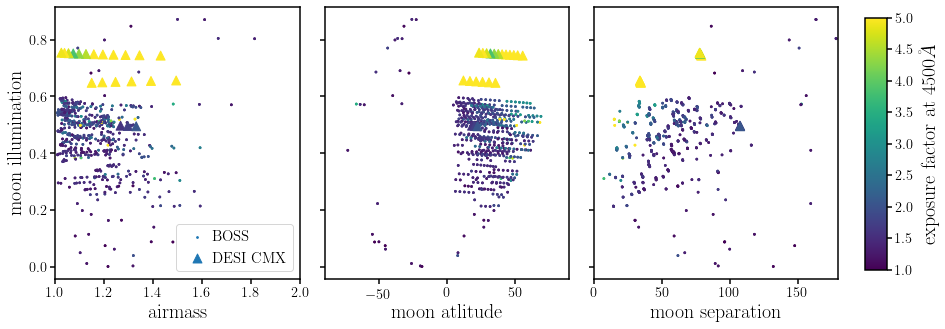

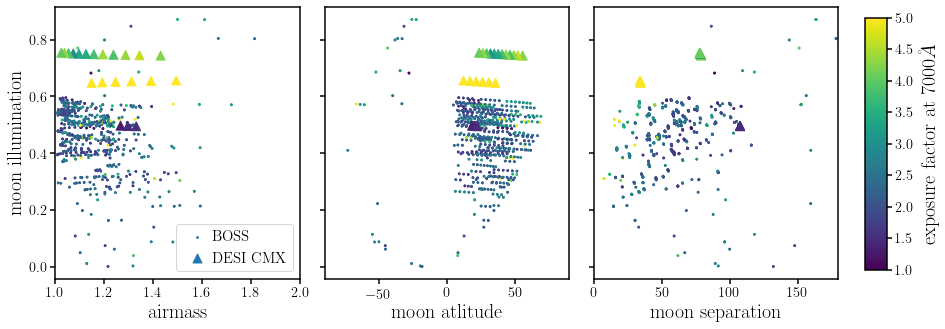

In [17]:
fig = plt.figure(figsize=(15,5))
sub = fig.add_subplot(131)
sub.scatter(boss_skies['airmass'], boss_skies['moon_ill'], c=boss_4500, s=3, vmin=1., vmax=5., label='BOSS')
sub.scatter(cmx_skies['airmass'], cmx_skies['moon_ill'], marker='^', c=desi_4500, s=80, vmin=1., vmax=5., label='DESI CMX')
sub.legend(loc='lower right', frameon=True, handletextpad=0, fontsize=15)
sub.set_xlabel('airmass', fontsize=20)
sub.set_xlim(1., 2.)
sub.set_ylabel('moon illumination', fontsize=20)

sub = fig.add_subplot(132)
sub.scatter(boss_skies['moon_alt'], boss_skies['moon_ill'], c=boss_4500, s=3, vmin=1., vmax=5.)
sub.scatter(cmx_skies['moon_alt'], cmx_skies['moon_ill'], marker='^', s=80, c=desi_4500, vmin=1., vmax=5.)
sub.set_xlabel('moon atlitude', fontsize=20)
sub.set_xlim(-90., 90.)
sub.set_yticklabels([])

sub = fig.add_subplot(133)
sct = sub.scatter(boss_skies['moon_sep'], boss_skies['moon_ill'], c=boss_4500, s=3, vmin=1., vmax=5.)
sub.scatter(cmx_skies['moon_sep'], cmx_skies['moon_ill'], marker='^', c=desi_4500, s=80, vmin=1., vmax=5.)
sub.set_xlabel('moon separation', fontsize=20)
sub.set_xlim(0., 180.)
sub.set_yticklabels([])

fig.subplots_adjust(wspace=0.1, hspace=0.1, right=0.85)
cbar_ax = fig.add_axes([0.875, 0.15, 0.02, 0.7])
cbar = fig.colorbar(sct, cax=cbar_ax)
cbar.set_label(label='exposure factor at $4500\AA$', fontsize=20)

fig = plt.figure(figsize=(15,5))
sub = fig.add_subplot(131)
sub.scatter(boss_skies['airmass'], boss_skies['moon_ill'], c=boss_7000, s=3, vmin=1., vmax=5., label='BOSS')
sub.scatter(cmx_skies['airmass'], cmx_skies['moon_ill'], marker='^', c=desi_7000, s=80, vmin=1., vmax=5., label='DESI CMX')
sub.legend(loc='lower right', frameon=True, handletextpad=0, fontsize=15)
sub.set_xlabel('airmass', fontsize=20)
sub.set_xlim(1., 2.)
sub.set_ylabel('moon illumination', fontsize=20)

sub = fig.add_subplot(132)
sub.scatter(boss_skies['moon_alt'], boss_skies['moon_ill'], c=boss_7000, s=3, vmin=1., vmax=5.)
sub.scatter(cmx_skies['moon_alt'], cmx_skies['moon_ill'], marker='^', c=desi_7000, s=80, vmin=1., vmax=5.)
sub.set_xlabel('moon atlitude', fontsize=20)
sub.set_xlim(-90., 90.)
sub.set_yticklabels([])

sub = fig.add_subplot(133)
sct = sub.scatter(boss_skies['moon_sep'], boss_skies['moon_ill'], c=boss_7000, s=3, vmin=1., vmax=5.)
sub.scatter(cmx_skies['moon_sep'], cmx_skies['moon_ill'], marker='^', c=desi_7000, s=80, vmin=1., vmax=5.)
sub.set_xlabel('moon separation', fontsize=20)
sub.set_xlim(0., 180.)
sub.set_yticklabels([])

fig.subplots_adjust(wspace=0.1, hspace=0.1, right=0.85)
cbar_ax = fig.add_axes([0.875, 0.15, 0.02, 0.7])
cbar = fig.colorbar(sct, cax=cbar_ax)
cbar.set_label(label='exposure factor at $7000\AA$', fontsize=20)

Lets compare these exposure factors to what is predicted by the current exposure time factor in `desisurvey` and `surveysim`

In [18]:
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline, Pipeline
from itertools import chain, combinations_with_replacement

In [19]:
_notwiCoefficients_4500 = np.array([1.71573612e-09, -5.60790479e-01, -1.48073306e+00,
     1.15296186e-01, 4.52848807e-02,  6.87825142e-01, -1.09204980e-01,
     -2.29003929e-02, 5.43115007e-02,  3.73159137e+00, -1.02979745e-02,
     -7.54139533e-02, -1.05738392e-03, -1.40087568e-03, -1.61643490e-04,
     -4.83874245e-01, -1.27069698e+00,  3.10724722e-02,  6.37391242e-03,
     6.03557732e+00, 1.93135069e-02,  6.44469267e-02, -4.85686295e-04,
     -1.14612065e-03, -5.46053442e-04,  4.53593491e-01, -6.38120677e-02,
     1.30231834e-01, 6.98885410e-05, -7.61371808e-04, -9.32261381e-04,
     6.59488169e-06, 1.78548384e-05,  1.37397769e-05,  2.42228917e-06])

def exposure_factor_model_v0(airmass, moon_frac, moon_sep, moon_alt, wavelength=4500):
    ''' exposure factor model version 0 implemented in desisurvey and surveysim
    '''
    theta = np.atleast_2d(np.array([airmass, moon_frac, moon_sep, moon_alt]).T)

    combs = chain.from_iterable(combinations_with_replacement(range(4), i) for i in range(0, 4))
    theta_transform = np.empty((theta.shape[0], 35))
    for i, comb in enumerate(combs):
        theta_transform[:, i] = theta[:, comb].prod(1)

    return np.dot(theta_transform, _notwiCoefficients_4500.T) - 1.9417946048367711

In [20]:
model_v0_4500 = exposure_factor_model_v0(
    np.concatenate([cmx_skies['airmass'], boss_skies['airmass']]),
    np.concatenate([cmx_skies['moon_ill'], boss_skies['moon_ill']]),
    np.concatenate([cmx_skies['moon_sep'], boss_skies['moon_sep']]),
    np.concatenate([cmx_skies['moon_alt'], boss_skies['moon_alt']]))

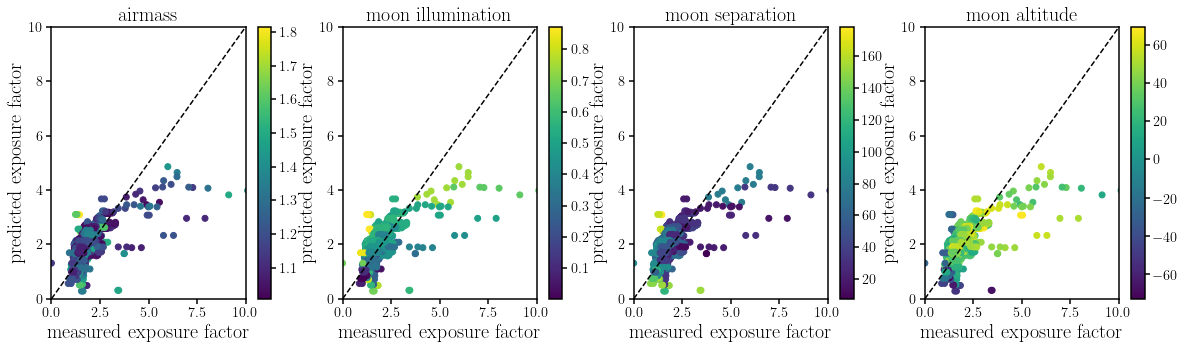

In [21]:
lbls = ['airmass', 'moon illumination', 'moon separation', 'moon altitude', 'sun separation', 'sun altitude']

fig = plt.figure(figsize=(20,5))
for i, k in enumerate(['airmass', 'moon_ill', 'moon_sep', 'moon_alt']):
    sub = fig.add_subplot(1,4,i+1)
    _plt = sub.scatter(np.concatenate([desi_4500, boss_4500]), model_v0_4500, c=np.concatenate([cmx_skies[k], boss_skies[k]]))
    sub.plot([0., 20.], [0., 20.], c='k', ls='--')
    sub.set_xlabel('measured exposure factor', fontsize=20)
    sub.set_xlim([0., 10.])
    sub.set_ylabel('predicted exposure factor', fontsize=20)
    sub.set_ylim([0., 10.])
    sub.set_title(lbls[i], fontsize=20)
    fig.colorbar(_plt)

Actually not terrible... but we can probably do better. Lets fit exposure factors using the DESI CMX and BOSS sky data

In [22]:
theta_train, theta_test, fexp_4500_train, fexp_4500_test = train_test_split(
    np.vstack([
        np.concatenate([cmx_skies['airmass'], boss_skies['airmass']]),
        np.concatenate([cmx_skies['moon_ill'], boss_skies['moon_ill']]),
        np.concatenate([cmx_skies['moon_sep'], boss_skies['moon_sep']]),
        np.concatenate([cmx_skies['moon_alt'], boss_skies['moon_alt']])]).T, 
    np.concatenate([desi_4500, boss_4500]), 
    test_size=0.2, 
    random_state=0)

In [23]:
n_order = 3
regress_fexp_4500 = make_pipeline(PolynomialFeatures(n_order), Ridge(alpha=0.1))
regress_fexp_4500.fit(theta_train, fexp_4500_train)

Pipeline(memory=None,
         steps=[('polynomialfeatures',
                 PolynomialFeatures(degree=3, include_bias=True,
                                    interaction_only=False, order='C')),
                ('ridge',
                 Ridge(alpha=0.1, copy_X=True, fit_intercept=True,
                       max_iter=None, normalize=False, random_state=None,
                       solver='auto', tol=0.001))],
         verbose=False)

In [24]:
steps = regress_fexp_4500.get_params()
_notwiCoefficients_4500_v1 = steps['ridge'].coef_
_notwiIntercept_v1 = steps['ridge'].intercept_

In [25]:
_notwiCoefficients_4500_v1

array([ 0.00000000e+00,  6.64249135e-01,  8.74636845e-01,  5.46119086e-02,
        2.09630540e-01,  7.71533535e-01,  2.43080508e+00, -3.37324907e-02,
       -1.31562925e-01,  1.76568937e+00, -1.72785334e-01, -4.12519964e-01,
        2.70218415e-04, -6.74720013e-04, -6.40615701e-04, -6.06114238e-02,
        4.20083806e+00, -4.01683814e-02, -2.23927383e-02,  4.26750164e+00,
       -1.24791583e-01, -1.34950879e-02,  9.74987299e-04,  2.04344664e-03,
        1.45017954e-03,  3.55655361e+00, -2.81204010e-02,  3.69329478e-01,
        1.74650674e-03,  1.60250805e-03,  3.85155358e-04, -8.17780306e-06,
       -1.51577067e-05, -1.35840537e-05, -5.20906511e-06])

In [26]:
_notwiIntercept_v1 

-1.2150087847104432

In [27]:
def exposure_factor_model_v1(airmass, moon_frac, moon_sep, moon_alt, wavelength=4500):
    ''' third degree polynomial regression fit to exposure factor
    '''
    if wavelength == 4500:
        _notwiCoefficients = _notwiCoefficients_4500_v1
        _notwiIntercept = _notwiIntercept_v1
    
    theta = np.atleast_2d(np.array([airmass, moon_frac, moon_sep, moon_alt]).T)

    combs = chain.from_iterable(combinations_with_replacement(range(4), i) for i in range(0, n_order+1))
    theta_transform = np.empty((theta.shape[0], len(_notwiCoefficients)))
    for i, comb in enumerate(combs):
        theta_transform[:, i] = theta[:, comb].prod(1)

    return np.dot(theta_transform, _notwiCoefficients.T) + _notwiIntercept

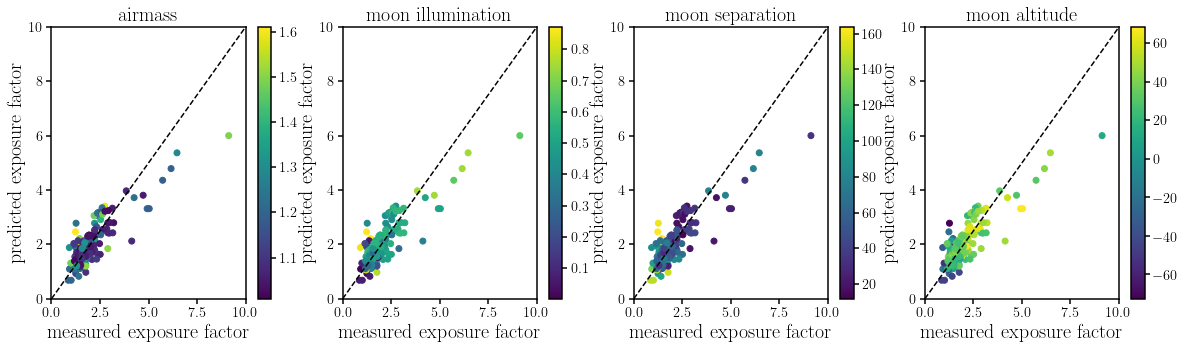

In [28]:
lbls = ['airmass', 'moon illumination', 'moon separation', 'moon altitude', 'sun separation', 'sun altitude']

fig = plt.figure(figsize=(20,5))
for i, k in enumerate(['airmass', 'moon_ill', 'moon_sep', 'moon_alt']):
    sub = fig.add_subplot(1,4,i+1)
    _plt = sub.scatter(fexp_4500_test, exposure_factor_model_v1(*theta_test.T), c=theta_test[:,i])
    sub.plot([0., 20.], [0., 20.], c='k', ls='--')
    sub.set_xlabel('measured exposure factor', fontsize=20)
    sub.set_xlim([0., 10.])
    sub.set_ylabel('predicted exposure factor', fontsize=20)
    sub.set_ylim([0., 10.])
    sub.set_title(lbls[i], fontsize=20)
    fig.colorbar(_plt)

In [29]:
desi_model_v1_4500 = exposure_factor_model_v1(cmx_skies['airmass'], cmx_skies['moon_ill'], cmx_skies['moon_sep'], cmx_skies['moon_alt'])
boss_model_v1_4500 = exposure_factor_model_v1(boss_skies['airmass'], boss_skies['moon_ill'], boss_skies['moon_sep'], boss_skies['moon_alt'])

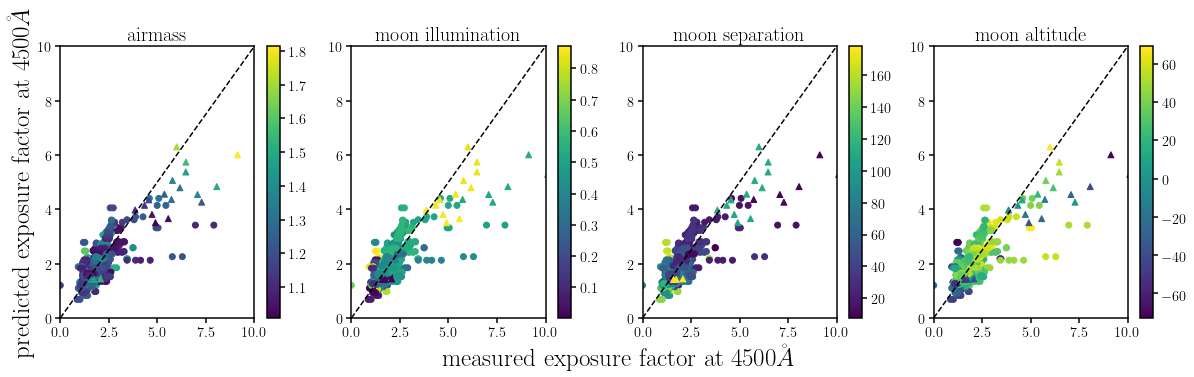

In [30]:
lbls = ['airmass', 'moon illumination', 'moon separation', 'moon altitude', 'sun separation', 'sun altitude']

fig = plt.figure(figsize=(20,5))
for i, k in enumerate(['airmass', 'moon_ill', 'moon_sep', 'moon_alt']):
    sub = fig.add_subplot(1,4,i+1)
    _plt = sub.scatter(boss_4500, boss_model_v1_4500, c=boss_skies[k])
    sub.scatter(desi_4500, desi_model_v1_4500, c=cmx_skies[k], marker='^')
    sub.plot([0., 20.], [0., 20.], c='k', ls='--')
    sub.set_xlim([0., 10.])
    if i == 0: sub.set_ylabel('predicted exposure factor at $4500\AA$', fontsize=25)
    sub.set_ylim([0., 10.])
    sub.set_title(lbls[i], fontsize=20)
    fig.colorbar(_plt)
    
bkgd = fig.add_subplot(111, frameon=False)
bkgd.set_xlabel('measured exposure factor at $4500\AA$', fontsize=25) 
bkgd.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)

The model v1 exposure factors aren't perfect but works pretty well for most of the DESI CMX exposures

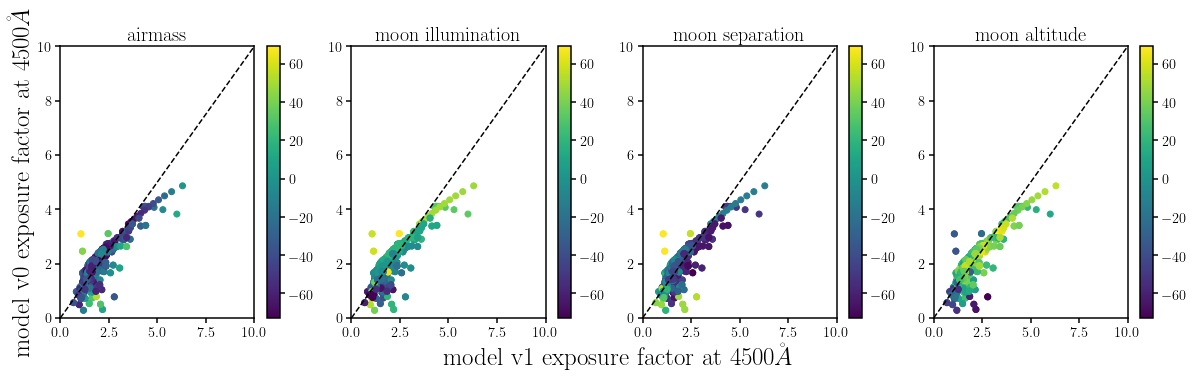

In [31]:
fig = plt.figure(figsize=(20,5))
for i, k in enumerate(['airmass', 'moon_ill', 'moon_sep', 'moon_alt']):
    sub = fig.add_subplot(1,4,i+1)
    sub.scatter(np.concatenate([desi_model_v1_4500, boss_model_v1_4500]), model_v0_4500, 
                c=np.concatenate([cmx_skies[k], boss_skies[k]]))
    sub.plot([0., 20.], [0., 20.], c='k', ls='--')
    sub.set_xlim([0., 10.])
    if i == 0: sub.set_ylabel('model v0 exposure factor at $4500\AA$', fontsize=25)
    sub.set_ylim([0., 10.])
    sub.set_title(lbls[i], fontsize=20)
    fig.colorbar(_plt)
    
bkgd = fig.add_subplot(111, frameon=False)
bkgd.set_xlabel('model v1 exposure factor at $4500\AA$', fontsize=25) 
bkgd.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)

## April 8, 2020 update
nominal exposure time calculations based on the above $4500\AA$ exposure factors are too conservative (i.e. redshift success rates too high). Lets try fitting the exposure factor at $7000 \AA$. 

In [32]:
theta_train, theta_test, fexp_7000_train, fexp_7000_test = train_test_split(
    np.vstack([
        np.concatenate([cmx_skies['airmass'], boss_skies['airmass']]),
        np.concatenate([cmx_skies['moon_ill'], boss_skies['moon_ill']]),
        np.concatenate([cmx_skies['moon_sep'], boss_skies['moon_sep']]),
        np.concatenate([cmx_skies['moon_alt'], boss_skies['moon_alt']])]).T, 
    np.concatenate([desi_7000, boss_7000]), 
    test_size=0.2, 
    random_state=0)

In [33]:
n_order = 3
regress_fexp_7000 = make_pipeline(PolynomialFeatures(n_order), Ridge(alpha=0.1))
regress_fexp_7000.fit(theta_train, fexp_7000_train)

Pipeline(memory=None,
         steps=[('polynomialfeatures',
                 PolynomialFeatures(degree=3, include_bias=True,
                                    interaction_only=False, order='C')),
                ('ridge',
                 Ridge(alpha=0.1, copy_X=True, fit_intercept=True,
                       max_iter=None, normalize=False, random_state=None,
                       solver='auto', tol=0.001))],
         verbose=False)

In [34]:
steps_7000 = regress_fexp_7000.get_params()
_notwiCoefficients_7000_v1 = steps_7000['ridge'].coef_
_notwiIntercept_7000_v1 = steps_7000['ridge'].intercept_

In [35]:
_notwiCoefficients_7000_v1

array([ 0.00000000e+00,  8.37707994e-01,  1.69728969e+00, -1.22451341e-01,
        9.88375492e-02,  7.17746023e-01,  2.12069891e+00, -1.96381608e-02,
       -1.76532675e-01,  2.44060866e+00, -3.09799460e-01, -1.86182063e-01,
        2.85846222e-03,  1.89986681e-03, -1.89164192e-04, -4.83041795e-01,
        2.27787205e+00, -2.40012601e-02,  7.80553188e-03,  4.74119022e+00,
       -9.01332722e-03, -4.83596159e-02,  3.00522374e-04,  1.71774283e-03,
        1.63075172e-03,  2.83037763e+00, -6.00379169e-02,  2.33975980e-01,
        2.01831833e-03,  6.89245918e-04,  4.12729616e-05, -1.58488809e-05,
       -2.70434515e-05, -2.10456280e-05, -6.45928584e-06])

In [36]:
_notwiIntercept_7000_v1

4.280003788471031

In [37]:
def exposure_factor_model_7000v1(airmass, moon_frac, moon_sep, moon_alt):
    ''' third degree polynomial regression fit to exposure factor
    '''
    theta = np.atleast_2d(np.array([airmass, moon_frac, moon_sep, moon_alt]).T)

    combs = chain.from_iterable(combinations_with_replacement(range(4), i) for i in range(0, n_order+1))
    theta_transform = np.empty((theta.shape[0], len(_notwiCoefficients_7000_v1)))
    for i, comb in enumerate(combs):
        theta_transform[:, i] = theta[:, comb].prod(1)

    return np.dot(theta_transform, _notwiCoefficients_7000_v1.T) + _notwiIntercept_7000_v1

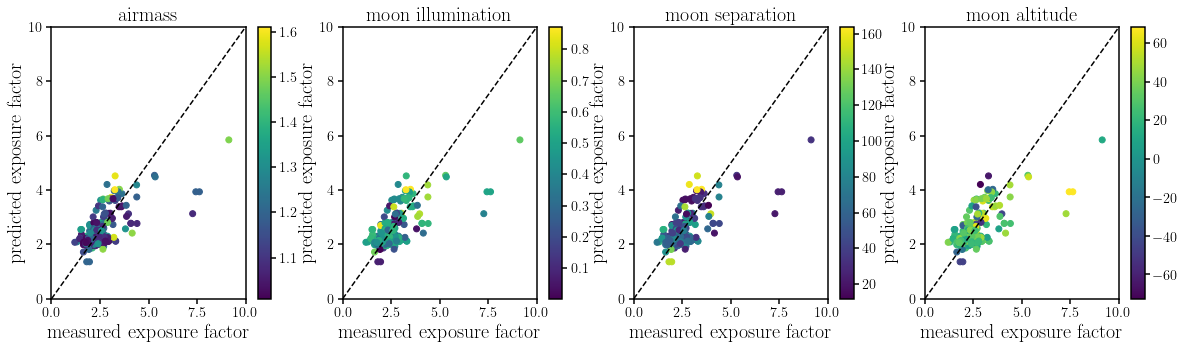

In [38]:
lbls = ['airmass', 'moon illumination', 'moon separation', 'moon altitude', 'sun separation', 'sun altitude']

fig = plt.figure(figsize=(20,5))
for i, k in enumerate(['airmass', 'moon_ill', 'moon_sep', 'moon_alt']):
    sub = fig.add_subplot(1,4,i+1)
    _plt = sub.scatter(fexp_7000_test, exposure_factor_model_7000v1(*theta_test.T), c=theta_test[:,i])
    sub.plot([0., 20.], [0., 20.], c='k', ls='--')
    sub.set_xlabel('measured exposure factor', fontsize=20)
    sub.set_xlim([0., 10.])
    sub.set_ylabel('predicted exposure factor', fontsize=20)
    sub.set_ylim([0., 10.])
    sub.set_title(lbls[i], fontsize=20)
    fig.colorbar(_plt)

In [39]:
desi_model_v1_7000 = exposure_factor_model_7000v1(cmx_skies['airmass'], cmx_skies['moon_ill'], cmx_skies['moon_sep'], cmx_skies['moon_alt'])
boss_model_v1_7000 = exposure_factor_model_7000v1(boss_skies['airmass'], boss_skies['moon_ill'], boss_skies['moon_sep'], boss_skies['moon_alt'])

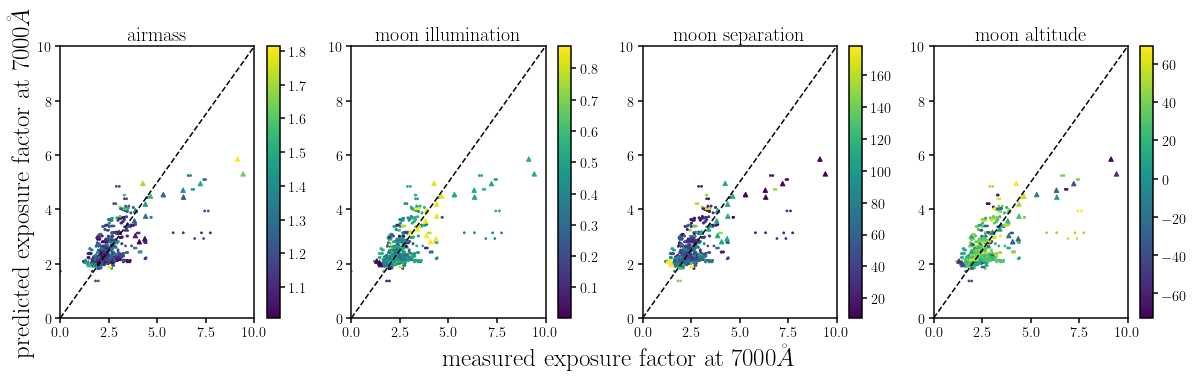

In [40]:
lbls = ['airmass', 'moon illumination', 'moon separation', 'moon altitude', 'sun separation', 'sun altitude']

fig = plt.figure(figsize=(20,5))
for i, k in enumerate(['airmass', 'moon_ill', 'moon_sep', 'moon_alt']):
    sub = fig.add_subplot(1,4,i+1)
    _plt = sub.scatter(boss_7000, boss_model_v1_7000, c=boss_skies[k], s=3)
    sub.scatter(desi_7000, desi_model_v1_7000, c=cmx_skies[k], s=20, marker='^')
    sub.plot([0., 20.], [0., 20.], c='k', ls='--')
    sub.set_xlim([0., 10.])
    if i == 0: sub.set_ylabel('predicted exposure factor at $7000\AA$', fontsize=25)
    sub.set_ylim([0., 10.])
    sub.set_title(lbls[i], fontsize=20)
    fig.colorbar(_plt)
    
bkgd = fig.add_subplot(111, frameon=False)
bkgd.set_xlabel('measured exposure factor at $7000\AA$', fontsize=25) 
bkgd.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)

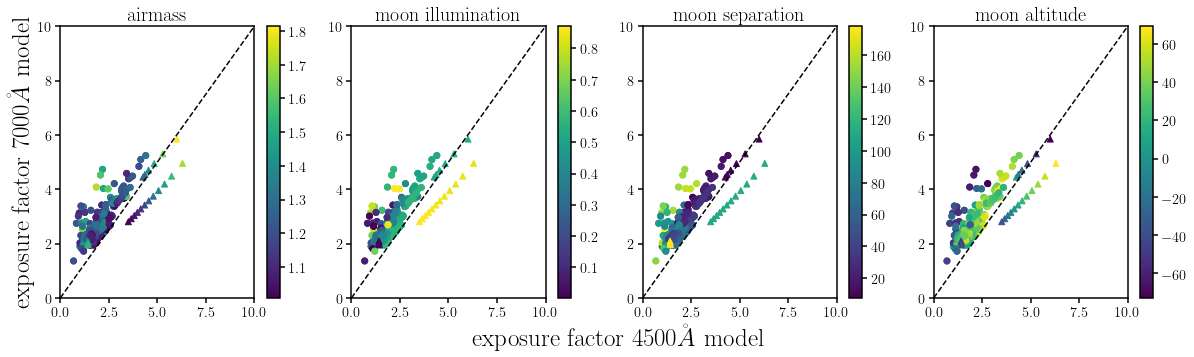

In [41]:
lbls = ['airmass', 'moon illumination', 'moon separation', 'moon altitude', 'sun separation', 'sun altitude']

fig = plt.figure(figsize=(20,5))
for i, k in enumerate(['airmass', 'moon_ill', 'moon_sep', 'moon_alt']):
    sub = fig.add_subplot(1,4,i+1)
    _plt = sub.scatter(boss_model_v1_4500, boss_model_v1_7000, c=boss_skies[k])
    sub.scatter(desi_model_v1_4500, desi_model_v1_7000, c=cmx_skies[k], marker='^')
    sub.plot([0., 20.], [0., 20.], c='k', ls='--')
    sub.set_xlim([0., 10.])
    if i == 0: sub.set_ylabel('exposure factor $7000\AA$ model', fontsize=25)
    sub.set_ylim([0., 10.])
    sub.set_title(lbls[i], fontsize=20)
    fig.colorbar(_plt)
    
bkgd = fig.add_subplot(111, frameon=False)
bkgd.set_xlabel('exposure factor $4500\AA$ model', fontsize=25) 
bkgd.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)